In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
import os
print(os.listdir("/Users/pavelmanyakin/Desktop/Data"))

['.DS_Store', 'AMZN.csv', 'MSFT.csv', 'NFLX.csv', 'GOOG.csv', 'AAPL.csv']


In [44]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NFLX']
folder = "/Users/pavelmanyakin/Desktop/Data/" #This should be changed to your folder with data

all_prices = []

for ticker in tickers:
    file_path = f"{folder}{ticker}.csv"
    print(f"Downloading {file_path}...")
    df = pd.read_csv(file_path, parse_dates=['Date'])

    price_col = 'Adjusted Close' if 'Adjusted Close' in df.columns else 'Adj Close'

    df = df[['Date', price_col]].rename(columns={price_col: ticker})
    all_prices.append(df)

data = all_prices[0]
for df in all_prices[1:]:
    data = data.merge(df, on='Date', how='inner')

data = data.set_index('Date')

start_date = "2010-06-01"
end_date = "2020-05-31"
data = data.loc[start_date:end_date]

returns = data.pct_change().dropna()

X_np = returns.values
X_mean = X_np.mean(axis=0)
X_std = X_np.std(axis=0)
X_norm = (X_np - X_mean) / X_std

x0_all = torch.tensor(X_norm, dtype=torch.float32)
print(f"Shape: shape = {x0_all.shape}")

/var/folders/ml/w52lgnpd681dr_dyz7dhqz9r0000gn/T/ipykernel_56662/107447334.py:9: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv(file_path, parse_dates=['Date'])
/var/folders/ml/w52lgnpd681dr_dyz7dhqz9r0000gn/T/ipykernel_56662/107447334.py:9: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv(file_path, parse_dates=['Date'])
/var/folders/ml/w52lgnpd681dr_dyz7dhqz9r0000gn/T/ipykernel_56662/107447334.py:9: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv(file_path, parse_dates=['Date'])
/var/folders/ml/w52lgnpd681dr_d

Shape: shape = torch.Size([2518, 5])


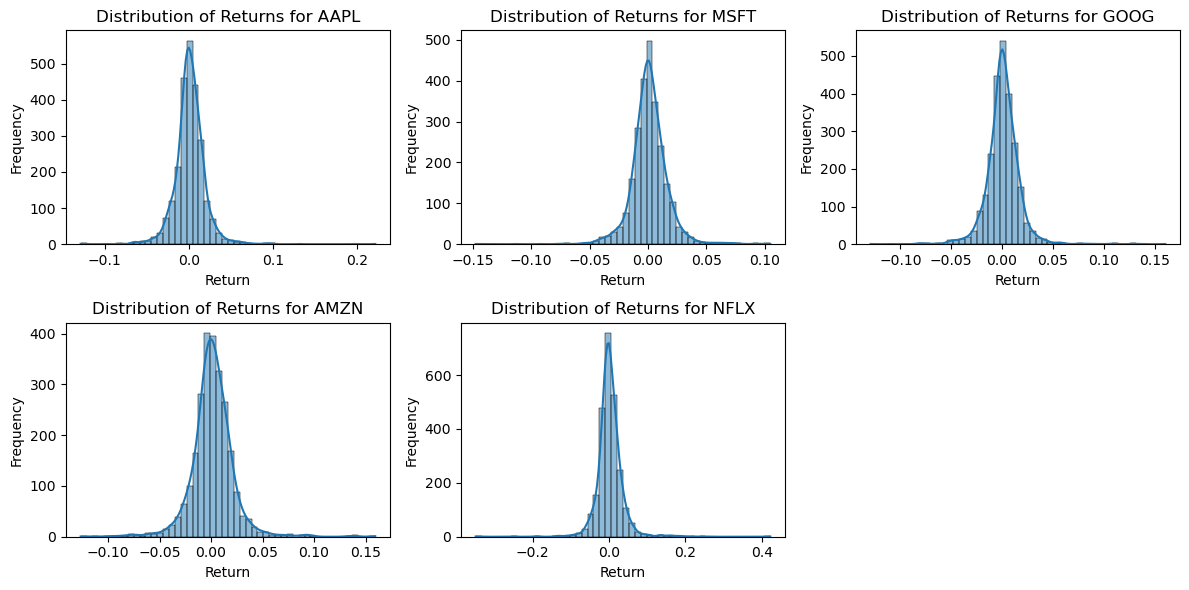

In [45]:
plt.figure(figsize=(12, 6))
for i, ticker in enumerate(tickers):
    plt.subplot(2, 3, i + 1)
    sns.histplot(returns[ticker], bins=50, kde=True)
    plt.title(f"Distribution of Returns for {ticker}")
    plt.xlabel("Return")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [12]:
def simulate_xt(x0, t):
    t = t.view(-1, 1)
    m_t = torch.exp(-t)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t))
    z = torch.randn_like(x0)
    xt = m_t * x0 + sigma_t * z
    return xt, z, m_t, sigma_t

In [16]:
device = "cpu"

In [18]:
import torch.nn as nn

class ScoreNet(nn.Module):
    def __init__(self, d=2, hidden_dim=256):
        super().__init__()
        input_dim = d + 1

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d)
        )


    def forward(self, x, t):
        if t.dim() == 1:
            t = t.unsqueeze(1)
        x_in = torch.cat([x, t], dim=1)
        return self.net(x_in)

In [20]:
def compute_H(net, x0, t, z):
    B, d = x0.shape

    m_t = torch.exp(-t_input).expand_as(x0)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t_input)).expand_as(x0)
    kappa_t = sigma_t ** 2
    x_t = m_t * x0 + sigma_t * z
    x_t.requires_grad_(True)

    s = net(x_t, t)

    total_grad = [torch.zeros_like(p) for p in net.parameters()]

    for i in range(B):
        x_i = x_t[i].view(1, -1).clone().detach().requires_grad_(True)
        t_i = t[i].view(1, 1)
        z_i = z[i]
        
        s_i = net(t_i, x_i)[0]
        sigma_inv_z = z_i / sigma_t[i]
        coeff = sigma_inv_z + s_i
        
        for j in range(d):
            grad_sij = torch.autograd.grad(
                outputs=s_i[j],
                inputs=list(net.parameters()),
                retain_graph=True,
                create_graph=True,
                allow_unused=True
            )

            for k in range(len(total_grad)):
                if grad_sij[k] is not None:
                    total_grad[k] += 2 * kappa_t[i, 0] * coeff[j] * grad_sij[k]

    return total_grad

In [22]:
def sgld_update(params, grads, lr, beta):
    updated = []
    for p, g in zip(params, grads):
        noise = torch.randn_like(p)
        noise_scale = (2 * lr / beta) ** 0.5
        p_new = p - lr * g + noise_scale * noise
        updated.append(p_new)
    return updated

In [23]:
net = ScoreNet()

In [24]:
net.eval()

ScoreNet(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [25]:
returns = data.pct_change().dropna()
X_np = returns.values
X_mean = X_np.mean(axis=0)
X_std = X_np.std(axis=0)
X_norm = (X_np - X_mean) / X_std
x0_all = torch.tensor(X_norm, dtype=torch.float32)

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ScoreNet(d=5).to(device)
B, d = 128, 5
lr = 1e-3
beta = 10**8
num_steps = 10000
grad_norms = []
theta_trajectory = []

In [27]:
best_H = float('inf')
theta_hat_best = None

for step in range(num_steps):
    indices = torch.randint(0, x0_all.shape[0], (B,))
    x0 = x0_all[indices].to(device)
    t = torch.rand(B).to(device)
    t_input = t.view(-1, 1)
    m_t = torch.exp(-t_input).expand_as(x0)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t_input)).expand_as(x0)
    z = torch.randn_like(x0)
    xt = m_t * x0 + sigma_t * z

    grads = compute_H(net, x0, t, z)

    grad_norm = torch.sqrt(sum(g.norm()**2 for g in grads if g is not None))
    grad_norms.append(grad_norm.item())

    updated_params = sgld_update(list(net.parameters()), grads, lr, beta)

    with torch.no_grad():
        for p, new_p in zip(net.parameters(), updated_params):
            p.copy_(new_p)

        H_value = sum((g**2).sum().item() for g in grads if g is not None)

        if H_value < best_H:
            best_H = H_value
            theta_hat_best = {
                name: p.detach().clone().cpu()
                for name, p in net.named_parameters()
            }

        theta = torch.cat([p.flatten() for p in net.parameters()])
        theta_trajectory.append(theta.cpu().numpy())

In [28]:
for name, p in net.named_parameters():
    print(name, torch.norm(p).item())и

net.0.weight 8.737494468688965
net.0.bias 3.7221367359161377
net.3.weight 11.993261337280273
net.3.bias 2.290959358215332
net.6.weight 11.1690673828125
net.6.bias 2.739840030670166
net.8.weight 4.151891231536865
net.8.bias 0.10171172767877579


In [29]:
with torch.no_grad():
    for name, p in net.named_parameters():
        p.copy_(theta_hat_best[name].to(p.device))

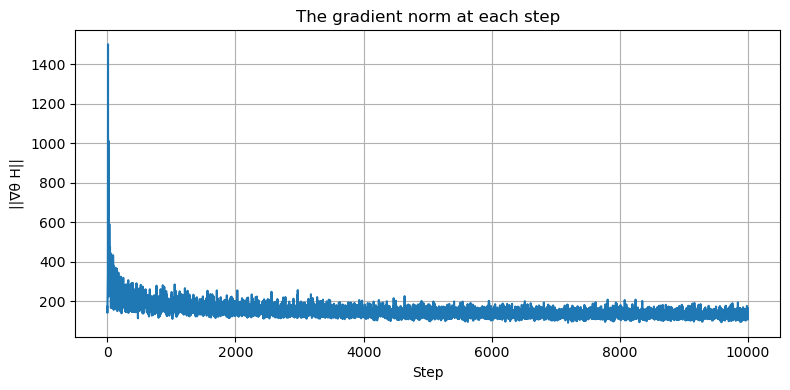

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(grad_norms)
plt.title("The gradient norm at each step")
plt.xlabel("Step")
plt.ylabel("||∇θ H||")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
from tqdm import tqdm


N_samples = 2518
dim = 5
K = 10000
T = 1.0
gamma = T/K
timesteps = np.linspace(0, T, K + 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
indices = torch.randint(0, x0_all.shape[0], (N_samples,))
x0 = x0_all[indices].to(device)
m_T = torch.exp(-torch.tensor(T)).expand_as(x0)
sigma_T = torch.sqrt(1 - torch.exp(-2 * torch.tensor(T))).expand_as(x0)
z = torch.randn_like(x0)
x_T = m_T * x0 + sigma_T * z
net.eval()
Y = x_T.clone()
for k in tqdm(range(K)):
    
    t_k = timesteps[k]
    tau = torch.full((N_samples, 1), T - t_k, device=device)

    with torch.no_grad():
        s_val = net(Y, tau)

    drift = Y + 2 * s_val
    noise = torch.randn_like(Y)
    Y = Y + gamma * drift + torch.sqrt(torch.tensor(2 * gamma)) * noise

samples = Y.cpu().numpy()

100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 736.53it/s]


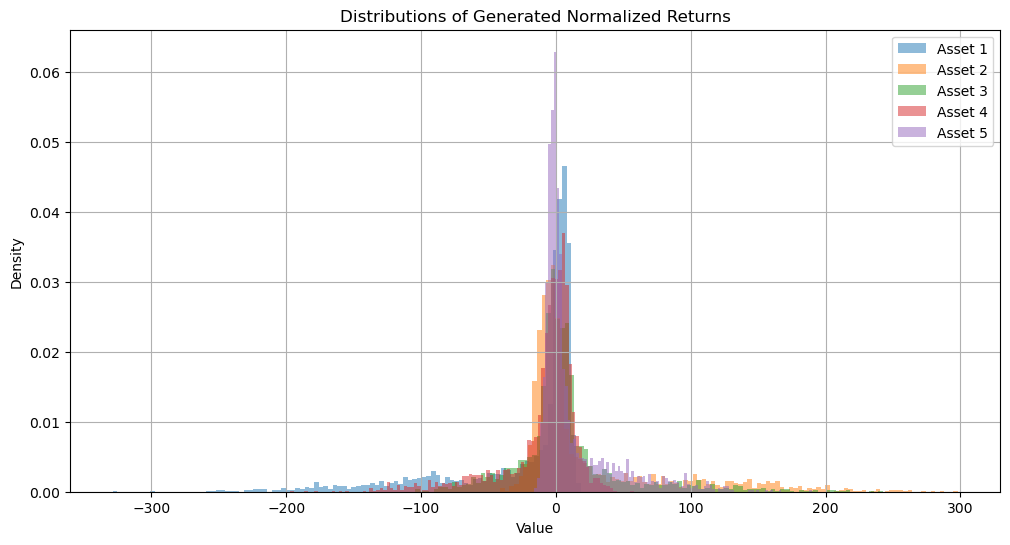

In [46]:
plt.figure(figsize=(12, 6))
for i in range(samples.shape[1]):
    plt.hist(samples[:, i], bins=100, alpha=0.5, density=True, label=f'Asset {i+1}')
plt.legend()
plt.title("Distributions of Generated Normalized Returns")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid()
plt.show()

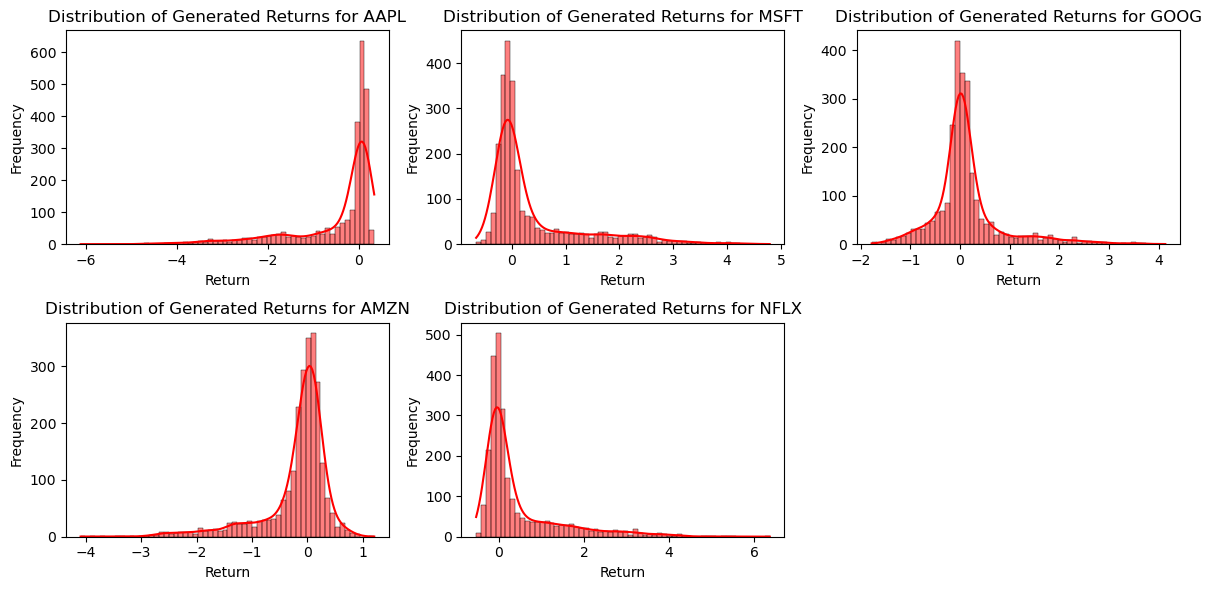

In [47]:
X_mean = X_np.mean(axis=0)
X_std = X_np.std(axis=0)
X_norm = (X_np - X_mean) / X_std
samples_denorm = samples * X_std + X_mean
df_gen = pd.DataFrame(samples_denorm, columns=tickers)
plt.figure(figsize=(12, 6))
for i, ticker in enumerate(tickers):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df_gen[ticker], bins=60, kde=True, color='red')
    plt.title(f"Distribution of Generated Returns for {ticker}")
    plt.xlabel("Return")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [35]:
mu_gen = samples.mean(axis=0)
cov_gen = np.cov(samples.T)

In [36]:
import cvxpy as cp

w = cp.Variable(dim)
target_return = mu_gen.mean()  

risk = cp.quad_form(w, cov_gen)
constraints = [
    cp.sum(w) == 1,
    mu_gen @ w >= target_return,
    w >= 0
]

prob = cp.Problem(cp.Minimize(risk), constraints)
prob.solve()

optimal_weights = w.value

Optimal portfolio weights:
AAPL: 0.1721
MSFT: 0.2769
GOOG: 0.2911
AMZN: 0.2598
NFLX: -0.0000


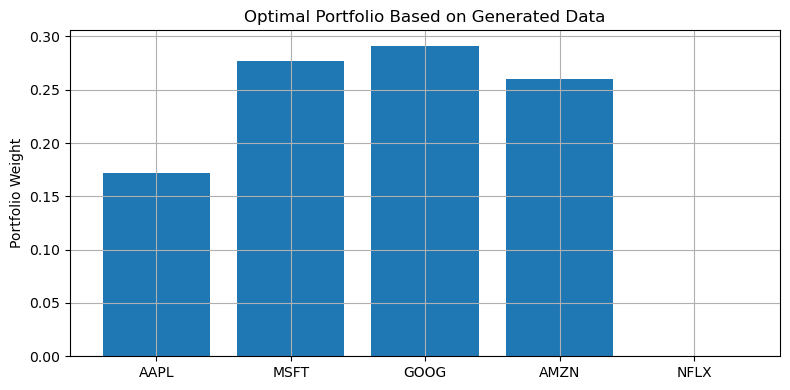

In [48]:
print("Optimal portfolio weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(tickers, optimal_weights)
plt.ylabel("Portfolio Weight")
plt.title("Optimal Portfolio Based on Generated Data")
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# Настройки
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NFLX']
folder = "/Users/pavelmanyakin/Desktop/Data/" #This should be changed to your folder with data
start_date = '2020-06-01'
end_date = '2020-09-01'
initial_investment = 100000
weights = np.array([0.1721, 0.2769, 0.2911, 0.2598, 0.0])

close_prices = pd.DataFrame()

for ticker in tickers:
    filepath = os.path.join(folder, f"{ticker}.csv")
    df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
    close_prices[ticker] = df['Adjusted Close']

close_prices = close_prices.loc[start_date:end_date]

start_prices = close_prices.iloc[0]
end_prices = close_prices.iloc[-1]

shares_bought = (initial_investment * weights) / start_prices
final_value = np.sum(shares_bought * end_prices)


print(f"Initial investment: ${initial_investment:,.2f}")
print(f"Final portfolio value after 2 months: ${final_value:,.2f}")
print(f"Return: {(final_value / initial_investment - 1) * 100:.2f}%")

/var/folders/ml/w52lgnpd681dr_dyz7dhqz9r0000gn/T/ipykernel_56662/2613305170.py:13: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
/var/folders/ml/w52lgnpd681dr_dyz7dhqz9r0000gn/T/ipykernel_56662/2613305170.py:13: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
/var/folders/ml/w52lgnpd681dr_dyz7dhqz9r0000gn/T/ipykernel_56662/2613305170.py:13: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv(filepath, parse_dates=['

Initial investment: $100,000.00
Final portfolio value after 2 months: $148,165.83
Return: 48.17%
